In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [3]:

# Altura(height) e largura (width) das imagens
# Channels se refere ao RGB

image_dimensions = {'height':256, 'width':256, 'channels':3}

In [4]:
# Cria a classe Classifier

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [5]:
# Cria uma classe MesoNet usando a classe Classifier como parametro

class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [6]:
# Carrega o modelo da MesoNet usando pesos pré-treinados
meso = Meso4()
meso.load('./weights/Meso4_DF.h5')

In [7]:
# Preparar as imagens

# Reescalando o valor dos pixeis de 255 para 0 e 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# nstanciando as imagens 
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 9054 images belonging to 2 classes.


In [8]:
# Checando a atribuição de cada classe
generator.class_indices

{'DeepFake': 0, 'Real': 1}

Predicted likelihood: 0.1828
Actual label: 0

Correct prediction: True


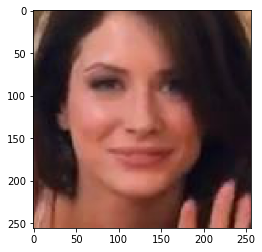

In [14]:
# Renderizando a imagem X com o label Y para a modelo do MesoNet
X, y = generator.next()

# Avaliação da previsão
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Mostrar a imagem
plt.imshow(np.squeeze(X));

In [15]:
# Criando listas para as imagens, classificadas corretas e incorretas
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [16]:

# Gerar previsões sobre o conjunto de validação, armazenando em listas separadas
for i in range(len(generator.labels)):
    
    # Carregamento da próxima imagem, gerando previsão
    X, y = generator.next()
    pred = meso.predict(X)[0][0]
    
    # Classificar na categoria adequada
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Atualização do estado de impressão
    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

0  predictions completed.
1000  predictions completed.
2000  predictions completed.
3000  predictions completed.
4000  predictions completed.
5000  predictions completed.
6000  predictions completed.
7000  predictions completed.
8000  predictions completed.
9000  predictions completed.
All 9054 predictions completed


In [17]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

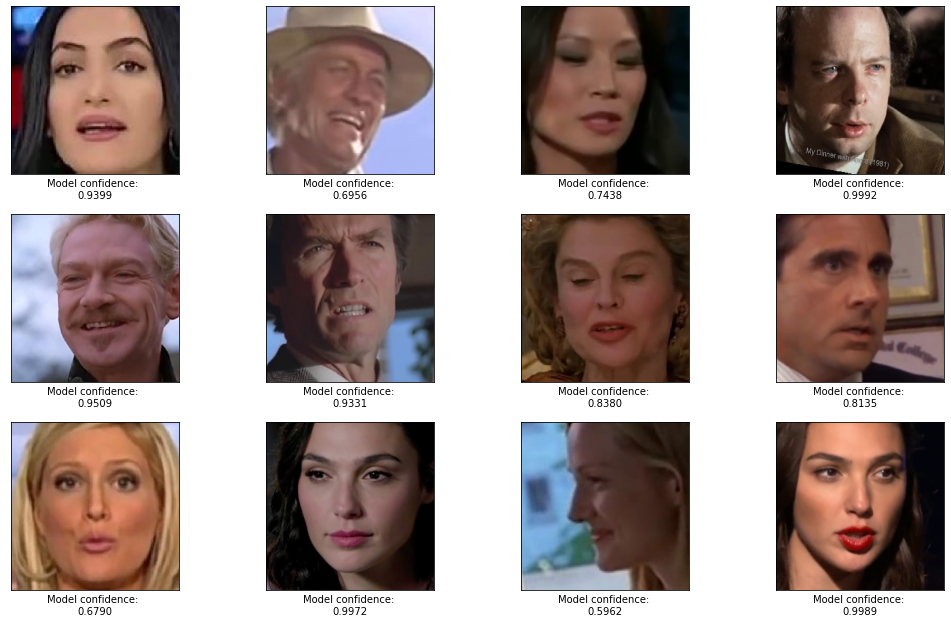

In [22]:

plotter(correct_real, correct_real_pred)

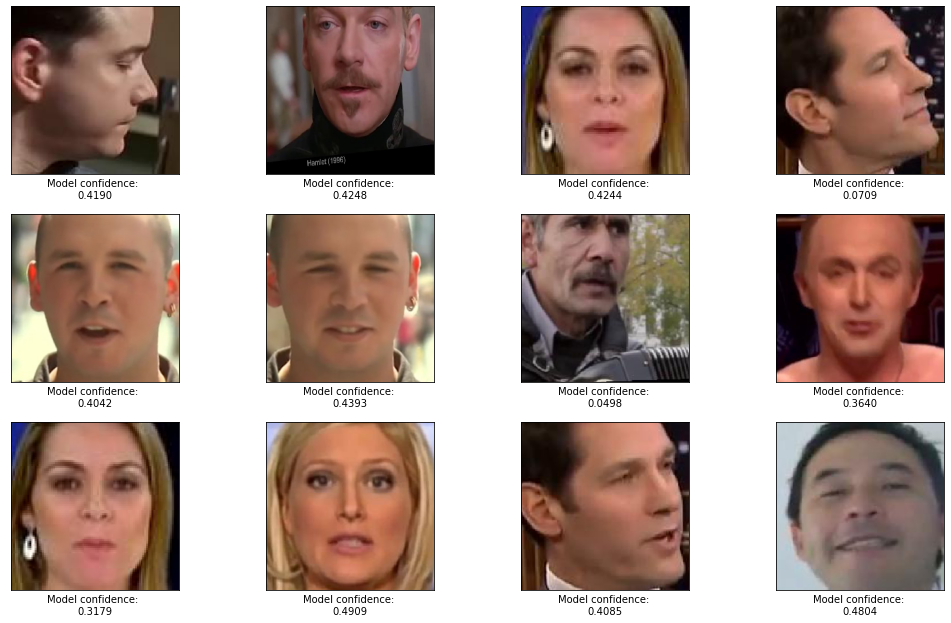

In [23]:
plotter(misclassified_real, misclassified_real_pred)

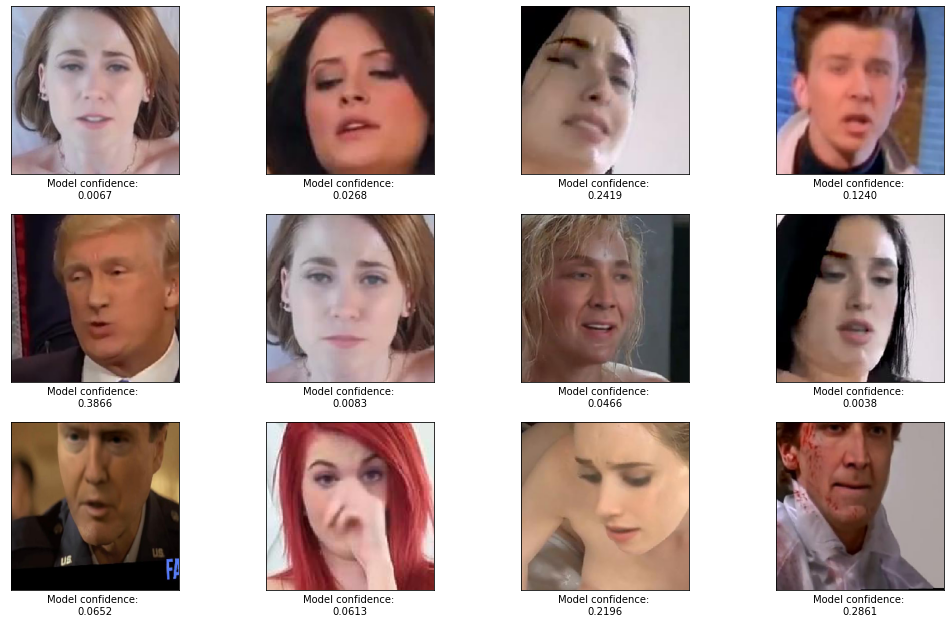

In [25]:

plotter(correct_deepfake, correct_deepfake_pred)

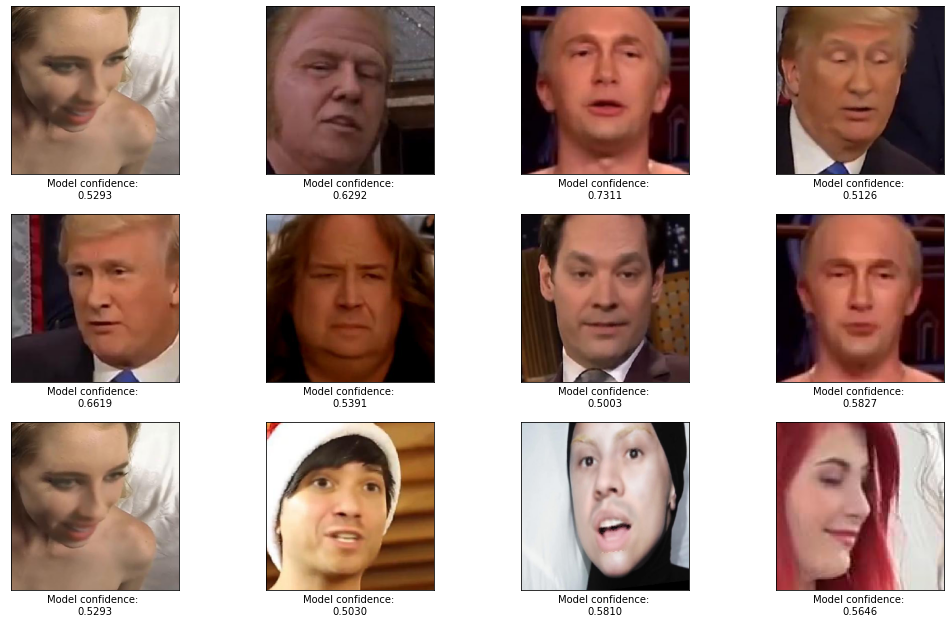

In [27]:

plotter(misclassified_deepfake, misclassified_deepfake_pred)